# Transfer learning project

### Prepare training data. Converting image to tensors

In [2]:
import os 
import tensorflow as tf

data_dir="../input/intel-image-classification/seg_train/seg_train"
training_data=[]

mapping_of_class={"buildings":0,"forest":1,"glacier":2,"mountain":3,"sea":4,"street":5}

for classname in os.listdir(data_dir):
    for image in os.listdir(data_dir+"/"+classname):
        opened_image=tf.keras.preprocessing.image.load_img(data_dir+"/"+classname+"/"+image,target_size=(120,120))
        image_as_tensor=tf.keras.preprocessing.image.img_to_array(opened_image)
        training_data.append([image_as_tensor,mapping_of_class[classname]])

In [3]:
import random
import numpy as np

random.shuffle(training_data)
X_train=[]
y_train=[]

for image,label in training_data:
    X_train.append(image)
    y_train.append(label)

X_train=np.array(X_train)

In [4]:
X_train.shape

(14034, 120, 120, 3)

### Repeat the same thing for evaluation data

In [5]:
test_dir="../input/intel-image-classification/seg_test/seg_test"
testing_data=[]

for testclassname in os.listdir(test_dir):
    for testimage in os.listdir(test_dir+"/"+testclassname):
        test_opened_image=tf.keras.preprocessing.image.load_img(test_dir+"/"+testclassname+"/"+testimage,target_size=(120,120))
        test_image_as_tensor=tf.keras.preprocessing.image.img_to_array(test_opened_image)
        testing_data.append([test_image_as_tensor,mapping_of_class[testclassname]])

In [6]:
X_test=[]
y_test=[]

for image,label in testing_data:
    X_test.append(image)
    y_test.append(label)
print(X_test[0]) 

X_test=np.array(X_test)



[[[130. 145. 186.]
  [131. 146. 187.]
  [134. 149. 190.]
  ...
  [117. 139. 188.]
  [120. 142. 191.]
  [121. 143. 192.]]

 [[131. 146. 187.]
  [131. 146. 187.]
  [134. 149. 190.]
  ...
  [117. 139. 188.]
  [120. 142. 191.]
  [121. 143. 192.]]

 [[125. 142. 185.]
  [125. 142. 185.]
  [128. 145. 188.]
  ...
  [121. 143. 192.]
  [118. 140. 189.]
  [117. 139. 188.]]

 ...

 [[ 67.  64.  31.]
  [ 44.  40.   2.]
  [ 55.  52.   7.]
  ...
  [ 83.  80.  45.]
  [ 85.  83.  44.]
  [ 66.  64.  23.]]

 [[ 43.  42.  12.]
  [ 58.  54.  19.]
  [ 66.  63.  20.]
  ...
  [ 89.  84.  46.]
  [112. 107.  67.]
  [ 78.  73.  33.]]

 [[ 26.  25.   0.]
  [ 74.  71.  38.]
  [ 67.  66.  22.]
  ...
  [ 65.  60.  20.]
  [ 75.  68.  26.]
  [ 54.  46.   7.]]]


In [7]:
X_test.shape

(3000, 120, 120, 3)

In [8]:
y_test=np.array(y_test)
y_train=np.array(y_train)

### Data augmentation

In [9]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
    
])

### Model declaration

In [10]:
base_model=tf.keras.applications.Xception(input_shape=(120,120,3),include_top=False,weights="imagenet")

83689472/83683744 [==============================] - 1s 0us/step


In [11]:
base_model.trainable=False
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 59, 59, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 59, 59, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 59, 59, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [12]:
preprocess=tf.keras.applications.mobilenet_v2.preprocess_input

inputs=tf.keras.Input(shape=(120,120,3))
#outputs=data_augmentation(inputs)
outputs=preprocess(inputs)
outputs=base_model(outputs,training=False)
outputs=tf.keras.layers.Flatten()(outputs)
outputs=tf.keras.layers.Dense(512,activation="relu")(outputs)
outputs=tf.keras.layers.Dropout(0.2)(outputs)
outputs=tf.keras.layers.Dense(6,activation="softmax")(outputs)
model=tf.keras.Model(inputs,outputs)

In [13]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 120, 120, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 120, 120, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dropout (Dropout)            (None, 512)              

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

In [15]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=32)

Epoch 1/5
439/439 [==============================] - 18s 41ms/step - loss: 0.6819 - accuracy: 0.8435 - val_loss: 0.3115 - val_accuracy: 0.8857
Epoch 2/5
439/439 [==============================] - 16s 37ms/step - loss: 0.3205 - accuracy: 0.8861 - val_loss: 0.3189 - val_accuracy: 0.8923
Epoch 3/5
439/439 [==============================] - 16s 37ms/step - loss: 0.2779 - accuracy: 0.8985 - val_loss: 0.3427 - val_accuracy: 0.8903
Epoch 4/5
439/439 [==============================] - 17s 38ms/step - loss: 0.2473 - accuracy: 0.9094 - val_loss: 0.3343 - val_accuracy: 0.8890
Epoch 5/5
439/439 [==============================] - 16s 37ms/step - loss: 0.2188 - accuracy: 0.9171 - val_loss: 0.3758 - val_accuracy: 0.8713


In [40]:

from PIL import Image
import matplotlib.pyplot as plt
classes=["buildings","forest","glacier","mountain","sea","street"]

import random
import string

letters = string.ascii_lowercase

def predict_img(img_url):
    img_name=''.join(random.choice(letters) for i in range(10))
    tf.keras.utils.get_file(img_name,origin=img_url,cache_subdir=os.path.abspath('.'))
    img_array = np.array(Image.open(os.path.abspath(img_name)))
    plt.imshow(img_array)
    opened_image=tf.keras.preprocessing.image.load_img(os.path.abspath(img_name),target_size=(120,120))
    image_as_tensor=tf.keras.preprocessing.image.img_to_array(opened_image)
    output=model.predict(image_as_tensor.reshape(1,120,120,3))
    print("Predicted:",classes[np.argmax(output)])
    


    
    

65536/60759 [================================] - 0s 0us/step
Predicted: glacier


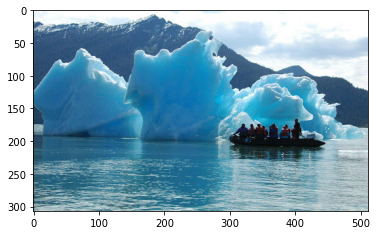

In [41]:
predict_img("https://lh3.googleusercontent.com/proxy/ELtlvJTN0Ewry-WURY3Pd7R3srgpG8QOz66cyWFgAc4t4SRmTkV5AOdFZWOICBPZYnsdQROcsmmCO6FQgFZLWs2EpaiWnnI6V5RlKst3nhFey96nGeTKtpKJtpaKqJa7zfRboCy403kXOdJJ4-6yAWQPkxDbe-qTOyAbCORQ4w")

40960/35211 [==================================] - 0s 0us/step
Predicted: street


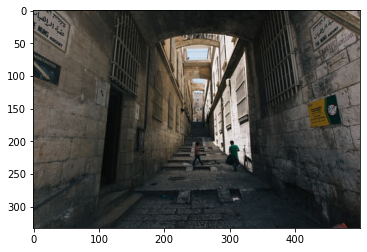

In [42]:
predict_img("https://images.unsplash.com/photo-1469818111566-67687db41ea7?ixid=MXwxMjA3fDB8MHxzZWFyY2h8MjB8fGJ1aWRsaW5nfGVufDB8fDB8&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60")

73728/71466 [==============================] - 0s 0us/step
Predicted: buildings


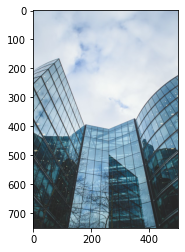

In [43]:
predict_img("https://images.unsplash.com/photo-1554469384-e58fac16e23a?ixid=MXwxMjA3fDB8MHxzZWFyY2h8NXx8YnVpbGRpbmd8ZW58MHx8MHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60")

### Save model

In [18]:
model.save("my_model")